In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import tensorflow as tf
from tensorflow.python.framework import ops
from tensorflow.contrib import learn
from tensorflow.contrib.learn.python.learn.estimators import model_fn as model_fn_lib
import math

%matplotlib inline
np.random.seed(1)

(200, 5)
(1000, 64, 64, 3)


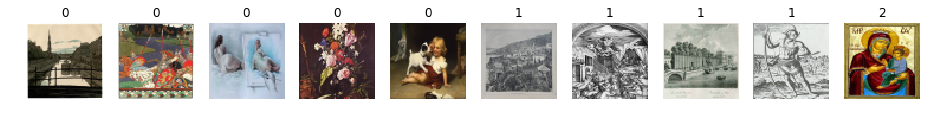

In [2]:
# Load data for AlexNet
# http://vision.stanford.edu/teaching/cs231b_spring1415/slides/alexnet_tugce_kyunghee.pdf
X_train = np.load(open("X_train.npy",'rb'))
Y_train = np.load(open("Y_train.npy",'rb'))
X_test = np.load(open("X_test.npy",'rb'))
Y_test = np.load(open("Y_test.npy", 'rb'))

print(Y_test.shape)
print(X_train.shape)

fig = plt.figure(figsize=(16, 8))
for i in range(10):
    img = X_train[190*i,:].reshape((64,64,3))
    fig.add_subplot(1, 10, i+1)
    plt.imshow(img)
    plt.axis('off')
    y_label = np.argmax(Y_train[190*i,:], axis=0)
    plt.title(y_label)
    
plt.show()

In [3]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    """
    Args:
    n_H0 -- integer, height of an input image
    n_W0 -- integer, width of an input image
    n_C0 -- integer, number of channels of the input
    n_y -- integer, number of classes
        
    Returns:
    X -- placeholder for the data input, of shape [None, n_H0, n_W0, n_C0] and dtype tf.float32
    Y -- placeholder for the input labels, of shape [None, n_y] and dtype tf.float32
    """

    X = tf.placeholder(tf.float32, shape=[None, n_H0, n_W0, n_C0])
    Y = tf.placeholder(tf.float32, shape=[None, n_y])
    
    return X, Y

In [4]:
def init_params():
    """
    Initializes weight parameters
    The shapes are:
        W1 : [11, 11, 3, 96]
        W2 : [5, 5, 96, 256]
        W3 : [3, 3, 256, 384]
        W4 : [3, 3, 384, 384]
        W5 : [3, 3, 384, 256]
    Returns:
    params -- a Python dict object containing W1, W2
    """
    
    tf.set_random_seed(1)
        
    W1 = tf.get_variable("W1", [11, 11, 3, 64], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    W2 = tf.get_variable("W2", [5, 5, 64, 192], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    W3 = tf.get_variable("W3", [3, 3, 192, 384], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    W4 = tf.get_variable("W4", [3, 3, 384, 256], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    W5 = tf.get_variable("W5", [3, 3, 256, 256], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    
    params = {'W1': W1, 'W2': W2, 'W3': W3, 'W4': W4, 'W5': W5}
    
    return params

In [5]:
def forward_propagation(X, params):
    """
    Implements the forward propagation for the model:
    
    
    Args:
    X -- input dataset placeholder
    parameters -- a Python dict containing 'W1' and 'W2'

    Returns:
    Z3 -- the output from the last fully connected layer
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = params['W1']
    W2 = params['W2']
    W3 = params['W3']
    W4 = params['W4']
    W5 = params['W5']
    
    # CONV2D: Filter 11x11, Depth 96, stride of 4, padding 'SAME'
    Z1 = tf.nn.conv2d(X, W1, strides = [1,4,4,1], padding = 'SAME')
    # RELU
    A1 = tf.nn.relu(Z1)
    # MAXPOOL: window 3x3, stride 2, padding 'SAME'
    P1 = tf.nn.max_pool(A1, ksize=[1,3,3,1], strides=[1,2,2,1], padding='SAME')
    
    # CONV2D: Filter 5x5, Depth 256, stride 1, padding 2
    Z2 = tf.nn.conv2d(P1, W2, strides = [1,1,1,1], padding = 'SAME')
    # RELU
    A2 = tf.nn.relu(Z2)
    # MAXPOOL: window 3x3, stride 2, padding 'SAME'
    P2 = tf.nn.max_pool(A2, ksize=[1,3,3,1], strides = [1,2,2,1], padding = 'SAME')
    
    #CONV2D: Filter 3x3, Depth 384, stride 1, padding 1
    Z3 = tf.nn.conv2d(P2, W3, strides = [1,1,1,1], padding = 'SAME')
    # RELU
    A3 = tf.nn.relu(Z3)
    
    #CONV2D: Filter 3x3, Depth 384, stride 1, padding 1
    Z4 = tf.nn.conv2d(A3, W4, strides = [1,1,1,1], padding = 'SAME')
    # RELU
    A4 = tf.nn.relu(Z4)
    
    #CONV2D: Filter 3x3, Depth 256, stride 1, padding 1
    Z5 = tf.nn.conv2d(A4, W5, strides = [1,1,1,1], padding = 'SAME')
    # RELU
    A5 = tf.nn.relu(Z5)
    # MAXPOOL: window 3x3, stride 2, padding 'SAME'
    P5 = tf.nn.max_pool(A5, ksize=[1,3,3,1], strides = [1,2,2,1], padding = 'SAME')

    P5 = tf.contrib.layers.flatten(P5)
    
    #Dropout rate 0.5
    D6 = tf.nn.dropout(P5, 0.5)
    #Fully Connected + RELU, 256*6*6*4096
    Z6 = tf.contrib.layers.fully_connected(D6, 256*6*6, activation_fn=None)
    
    #Dropout rate 0.5
    D7 = tf.nn.dropout(Z6, 0.5)
    #Fully Connected + RELU 4096*4096
    Z7 = tf.contrib.layers.fully_connected(D7, 4096, activation_fn=None)

    #Fully Connected + RELU 4096*1000
    Z8 = tf.contrib.layers.fully_connected(Z7, 5, activation_fn=None)

    return Z8

In [6]:
def compute_cost(Z8, Y):
    """
    Args:
    Z8 -- output of forward propagation 
    Y -- placeholder for ground truth, same shape as Z3
    
    Returns:
    cost - cost function
    """

    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits = Z8, labels = Y))
    
    return cost

In [7]:
def model(X_train, Y_train, X_test, Y_test, learning_rate=0.0001,
          num_epochs=100, print_cost=True):
    """
    Implements AlexNet ConvNet in Tensorflow:
    CONV2D, RELU, MAXPOOL, CONV2D, RELU, MAXPOOL, CONV2D, RELU, CONV, RELU, CONV, RELU, MAXPOOL,
    DROPOUT, FUllyCONNECTED, DROPOUT, FULLYCONNECTED, FULLYCONNECTED
    
    Args:
    X_train -- training set, of shape (None, 64, 64, 3)
    Y_train -- test set, of shape (None, 5)
    X_test -- training set, of shape (None, 64, 64, 3)
    Y_test -- test set, of shape (None, 5)
    learning_rate -- learning rate 
    num_epochs -- number of epochs
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    train_acc -- accuracy on the train set (X_train)
    test_acc -- testing accuracy on the test set (X_test)
    params -- parameters learnt by the model
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep results consistent (tensorflow seed)
    seed = 3                                          # to keep results consistent (numpy seed)
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of the correct shape. Call create_placeholders()
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)

    # Initialize parameters. Call init_params()
    params = init_params()
    
    # Forward propagation. Call forward_propagation()
    Z8 = forward_propagation(X, params)
    
    # Cost function. Call compute_cost()
    cost = compute_cost(Z8, Y)
    
    # Use an AdamOptimizer that minimizes the cost.
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    # Initialize all the variables globally
    init = tf.global_variables_initializer()
    
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Training loop
        for epoch in range(num_epochs):
            
            epoch_cost = 0.
            seed = seed + 1
                        
            # Run the session to execute the optimizer and the cost.
            _ , temp_cost = sess.run( [optimizer,cost], feed_dict={X: X_train, Y: Y_train})
            
            epoch_cost += temp_cost / m     # Normalize

            # Print the cost every epoch
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(epoch_cost)
        
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title('Learning rate =' + str(learning_rate))
        plt.show()

        # Calculate the correct predictions
        predict_op = tf.argmax(Z8, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        # Calculate accuracy on the test set
        acc = tf.reduce_mean(tf.cast(correct_prediction, 'float'))
        print(acc)
        train_acc = acc.eval({X: X_train, Y: Y_train})
        test_acc = acc.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_acc)
        print("Test Accuracy:", test_acc)
        
        return train_acc, test_acc, params

Cost after epoch 0: 0.010252
Cost after epoch 5: 0.007561
Cost after epoch 10: 0.003287
Cost after epoch 15: 0.001851
Cost after epoch 20: 0.001428
Cost after epoch 25: 0.001175
Cost after epoch 30: 0.001125
Cost after epoch 35: 0.000983
Cost after epoch 40: 0.000937
Cost after epoch 45: 0.000876
Cost after epoch 50: 0.000802
Cost after epoch 55: 0.000709
Cost after epoch 60: 0.000668
Cost after epoch 65: 0.000604
Cost after epoch 70: 0.000534
Cost after epoch 75: 0.000477
Cost after epoch 80: 0.000426
Cost after epoch 85: 0.000370
Cost after epoch 90: 0.000309
Cost after epoch 95: 0.000260


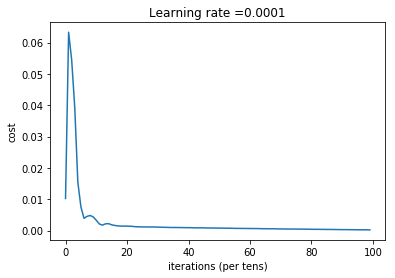

Tensor("Mean_1:0", shape=(), dtype=float32)
Train Accuracy: 0.927
Test Accuracy: 0.68
Total time to run: 3403.092465186237


In [8]:
t0 = time.clock()
_, _, parameters = model(X_train, Y_train, X_test, Y_test)
t1 = time.clock()
print("Total time to run:", t1-t0)